In [1]:
import Simulation.EHR_sensitive as ehrsens
from Simulation.loaddata import aggregate_dataset
from Simulation.extract_feats import generate_features

from Code.Analysis.compute_qualitymeasures import compute_qualitymeasures
import Code.Beam_Search.beam_search as bs

import pandas as pd
import numpy as np
import re
import ast
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sb

This file is run to:
* Generate the EHR data
* Clean and extract features from the ECG signals
* Aggregate the dataset into the wished format

The only values to change are the ones in the codeblock below:


In [2]:
# Only change these!
dataset = 'CPSC'
do = False #Change to True if you actually want to run the feature extraction process
exists = False #Change to True if you already have a dataset that you want to build on with the features
aggregate = False #Change to True if you want to aggregate the dataset of features

# Generate EHR


In [3]:
df_EHR = ehrsens.generate_EHR(dataset, vals = 97, other=True)
df_EHR.head(5)

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a48,a49,a50,a51,a52,a53,a54,a55,a56,a57
0,80,Female,UW,3,0. None,2. Uses,1. Used,1933,866,1627,...,Taken,Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken
1,77,Male,OW,6,2. Uses,2. Uses,0. None,0,0,2166,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Taken,Not Taken,Not Taken
2,80,Female,HW,5,0. None,2. Uses,1. Used,1142,1125,0,...,Taken,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Taken,Not Taken,Not Taken,Not Taken
3,77,Male,UW,6,0. None,2. Uses,0. None,0,0,1835,...,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken
4,51,Female,UW,6,1. Used,2. Uses,0. None,886,0,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Not Taken


# Generate features

In [4]:
if do:
    fts = generate_features(dataset)

In [5]:
if do:
    df_fts = pd.DataFrame.from_dict(fts)
    df_fts.head()

In [6]:
if do:
    if not(exists):
        df_fts.to_csv('synth_feats.csv', index=False) 
    else:
        df_old = pd.read_csv('synth_feats.csv')
        df_new = pd.concat([df_old, df_fts], axis=0)
        df_new.to_csv('synth_feats.csv', index=False) 

# Aggregate databse

In [7]:
if aggregate:
    df_old = pd.read_csv('synth_feats.csv')
    df_agg = aggregate_dataset(df_old)

    # Create a new database per patient, including which subgroup(s) it is included in and what they counter says
    nonAF = []
    AFpers = []
    AFparo = []

    for row in range(len(df_agg)):
        pat = df_agg.iloc[row]
        cs = Counter( ast.literal_eval(pat['AF']))
        nonAF.append(cs['non atrial fibrillation'])
        AFpers.append(cs['persistent atrial fibrillation'])
        AFparo.append(cs['paroxysmal atrial fibrillation'])

    df_agg['Non AF'] = nonAF
    df_agg['Persistent AF'] = AFpers
    df_agg['Paroxysmal AF'] = AFparo
    df_agg.to_csv('synth_aggregated_feats.csv', index=False)

# Get model class values

In [8]:
path = 'synth_aggregated_feats.csv'
savepath = 'synth_QualityMeasures.csv'

doqm = False
if doqm:
    compute_qualitymeasures(path, savepath)

qm = pd.read_csv('synth_QualityMeasures.csv')


In [9]:
df_EHR['PID'] = [i for i in range(len(qm))]
df_EHR

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a49,a50,a51,a52,a53,a54,a55,a56,a57,PID
0,80,Female,UW,3,0. None,2. Uses,1. Used,1933,866,1627,...,Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,0
1,77,Male,OW,6,2. Uses,2. Uses,0. None,0,0,2166,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Taken,Not Taken,Not Taken,1
2,80,Female,HW,5,0. None,2. Uses,1. Used,1142,1125,0,...,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Taken,Not Taken,Not Taken,Not Taken,2
3,77,Male,UW,6,0. None,2. Uses,0. None,0,0,1835,...,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,3
4,51,Female,UW,6,1. Used,2. Uses,0. None,886,0,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Not Taken,Not Taken,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,70,Male,HW,4,2. Uses,1. Used,2. Uses,0,1537,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Taken,Not Taken,Taken,Not Taken,92
93,66,Female,HW,3,1. Used,0. None,0. None,1902,542,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,93
94,57,Male,OW,2,2. Uses,2. Uses,2. Uses,0,736,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,94
95,65,Male,HW,4,2. Uses,0. None,2. Uses,623,0,0,...,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Not Taken,Taken,Taken,95


In [ ]:
beamdo = False

if beamdo:
    resultsDct = {'Theta': [], 'Rank': [], 'Description': [], 'QM': [], 'Indexes': []}
    for opt in ['SDSD', 'RMSSD', 'SDRR', 'P-count', 'F-count', 'SDSD_P', 'RMSSD_P', 'SDRR_P', 'SDSD_F', 'RMSSD_F', 'SDRR_F']:
        resultSet = bs.beam_search(df_EHR, qm, theta = opt, q = 5, w = 20, d = 3, b = 3, c = 3)
        resultsDct['Rank'] += [i for i in range(1, 6)]
        resultsDct['Theta'] += [opt for i in range(1, 6)]
        for res in resultSet:
        
            resultsDct['Description'].append([res[0]])
            resultsDct['QM'].append(float(res[1]))
            resultsDct['Indexes'].append([int(i) for i in res[2]])

        resultSet = []
        
    df_results = pd.DataFrame.from_dict(resultsDct)
    df_results.to_csv('synth_results.csv', index=False)

In [13]:
df_results = pd.read_csv("synth_results.csv")
df_results.head()

,Unnamed: 0,Theta,Rank,Description,QM,Indexes
0,0,SDSD,1,"[{'description': {'a46': ['Taken'], 'a39': ['T...",4.52,"[12, 38, 71]"
1,1,SDSD,2,"[{'description': {'a46': ['Taken'], 'a39': ['T...",3.61,"[12, 36, 38, 71]"
2,2,SDSD,3,"[{'description': {'a46': ['Taken'], 'a39': ['T...",3.27,"[12, 27, 36, 38, 71]"
3,3,SDSD,4,"[{'description': {'a46': ['Taken'], 'a39': ['T...",3.05,"[12, 36, 38]"
4,4,SDSD,5,"[{'description': {'a46': ['Taken'], 'a39': ['T...",3.01,"[12, 36, 38, 71, 74]"


In [12]:
df_agg = pd.read_csv("synth_aggregated_feats.csv")
df_agg.head(1)

,Unnamed: 0,PID,P-existence,F-existence,AF,RR-interval,SQ-duration,Wave Count,Q-location,Extra Waves,R-location,SQ-difference,QRS-duration,RR-difference,S-location,Non AF,Persistent AF,Paroxysmal AF
0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['non atrial fibrillation', 'non atrial fibril...","[156, 157, 157, 159, 160, 159, 161, 160, 157, ...","[139, 138, 140, 140, 142, 141, 143, 142, 140, ...","[3, 3, 3, 3, 4, 3, 5, 4, 3, 5, 3, 3, 4, 3, 2, ...","[167, 323, 479, 637, 795, 955, 1114, 1275, 143...","[0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, ...","[175, 331, 488, 645, 804, 964, 1123, 1284, 144...","[1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 4, 1, 0, 4, ...","[17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[1, 0, 2, 1, 1, 2, 1, 3, 3, 0, 2, 3, 1, 0, 3, ...","[184, 341, 497, 655, 813, 973, 1132, 1293, 145...",15,0,0


Bar_part     1  2  3  4  5
Cluster Bar               
1       4    5  0  0  0  0
        5    0  0  0  5  0
3       3    4  4  0  0  0
        4    0  0  5  3  0
        5    1  0  0  0  0
4       4    0  0  0  0  4
5       2    0  0  0  3  0
        4    0  0  4  0  0

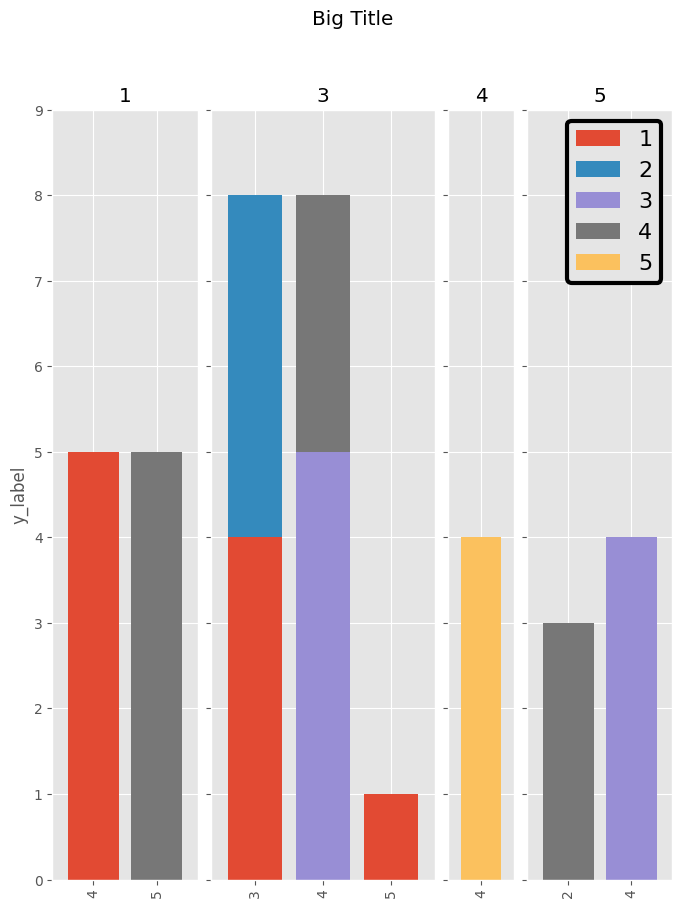

In [29]:
# plotting
# Data and imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.style.use('ggplot')

np.random.seed(0)

df = pd.DataFrame(np.asarray(1+5*np.random.random((10,4)), dtype=int),columns=["Cluster", "Bar", "Bar_part", "Count"])
df = df.groupby(["Cluster", "Bar", "Bar_part"])["Count"].sum().unstack(fill_value=0)
display(df)
clusters = df.index.levels[0]
inter_graph = 0
maxi = np.max(np.sum(df, axis=1))
total_width = len(df)+inter_graph*(len(clusters)-1)

fig = plt.figure(figsize=(total_width,10))
gridspec.GridSpec(1, total_width)
axes=[]

ax_position = 0
for cluster in clusters:
    subset = df.loc[cluster]
    ax = subset.plot(kind="bar", stacked=True, width=0.8, ax=plt.subplot2grid((1,total_width), (0,ax_position), colspan=len(subset.index)))
    axes.append(ax)
    ax.set_title(cluster)
    ax.set_xlabel("")
    ax.set_ylim(0,maxi+1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_position += len(subset.index)+inter_graph

for i in range(1,len(clusters)):
    axes[i].set_yticklabels("")
    axes[i-1].legend().set_visible(False)
axes[0].set_ylabel("y_label")

fig.suptitle('Big Title', fontsize="x-large")
legend = axes[-1].legend(loc='upper right', fontsize=16, framealpha=1).get_frame()
legend.set_linewidth(3)
legend.set_edgecolor("black")

plt.show()

Text(0.5, 0.98, 'Atrial Fibrillation in the subgroups found with the SDRR_F quality measure')

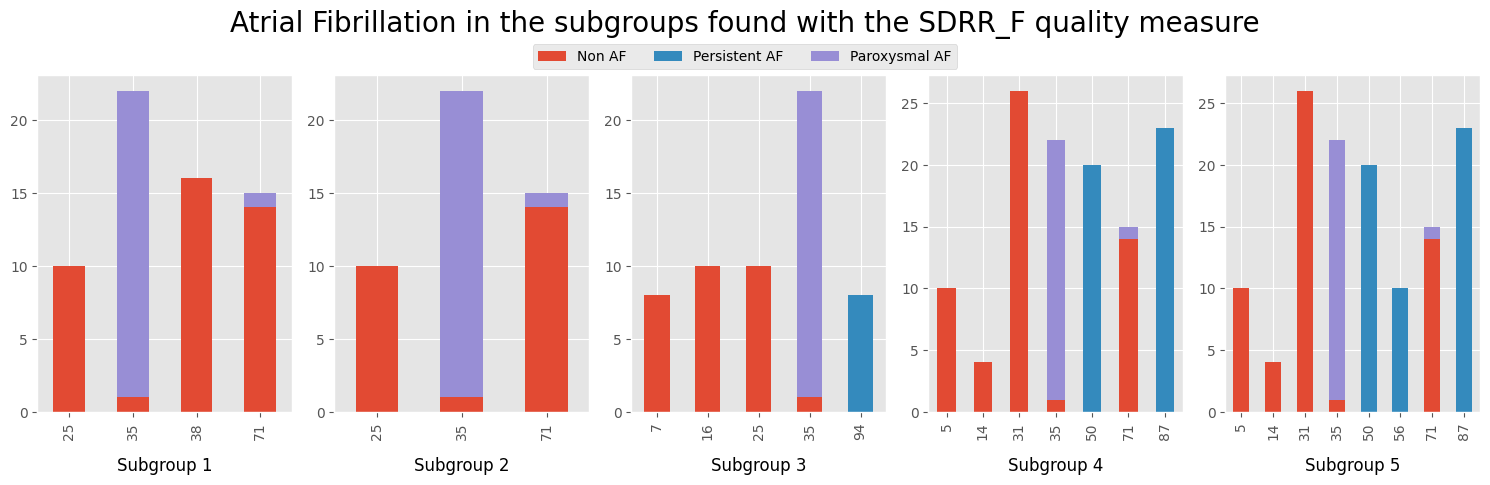

In [108]:
opt = 'SDRR_F'



new = True
sdsd = df_results[df_results['Theta'] == opt]

for row in range(5):
    result = sdsd.iloc[row]
    indexes = ast.literal_eval(result['Indexes'])
    
    pat = df_agg.iloc[indexes][['PID', 'Non AF', 'Persistent AF', 'Paroxysmal AF']]
    pat['Rank'] = len(indexes) * [row + 1]

    # Plot stacked bars for each patient, grouped by subgroup
    if new:
        newdf = pat
        new = False
    
    else:
        newdf = pd.concat([pat, newdf])
     
df = newdf.groupby(["Rank"])

fig, axes = plt.subplots(1, 5, figsize=(15,5))

for (k,d), ax in zip(df, axes.flat):
    interest = d[['Non AF', 'Persistent AF', 'Paroxysmal AF']]
    interest.plot.bar(stacked=True, ax=ax)
    ax.set_title(f"Subgroup {k[0]}", fontsize=12, y=-0.2)
    ax.legend().set_visible(False)


# Adjust the layout to make space for the figure title
fig.tight_layout()
# Use `rect` to make space for the suptitle
fig.subplots_adjust(top=0.85)
# Collect handles and labels from each subplot
# Collect unique handles and labels
handles, labels = [], []
seen_labels = set()

# Iterate over the axes and collect handles/labels
for ax in axes.flatten():
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in seen_labels:
            handles.append(handle)
            labels.append(label)
            seen_labels.add(label)

# Add a combined legend to the main figure
fig.legend(handles, labels, loc='upper center',  bbox_to_anchor=(0.5, 0.925), ncol=3)
fig.suptitle(f"Atrial Fibrillation in the subgroups found with the {opt} quality measure", fontsize=20)


In [111]:
qm['SDSD'].mean()

np.float64(31.033814432989693)

In [114]:
for d in df_results[df_results['Theta'] == 'SDSD']['Description']:
    print(d)

[{'description': {'a46': ['Taken'], 'a39': ['Taken'], 'a11': (np.float64(370.99999999999966), np.float64(1911.0))}}]
[{'description': {'a46': ['Taken'], 'a39': ['Taken'], 'a4': ['1', '2', '3', '4']}}]
[{'description': {'a46': ['Taken'], 'a39': ['Taken'], 'a1': (np.float64(51.0), np.float64(73.0))}}]
[{'description': {'a46': ['Taken'], 'a39': ['Taken'], 'a12': (np.float64(327.9999999999997), np.float64(1950.0))}}]
[{'description': {'a46': ['Taken'], 'a39': ['Taken'], 'a6': ['0. None', '1. Used']}}]
